# Example: Nonuniform Illumination
This example demonstrates defining a linear operator and solving a least squares problem in SCICO.

## Introduction
You set up a new microscope in your lab and take a brightfield image, which we'll call $y_1$.

Run the next cell to see $y_1$.

The shape of y1 is (350, 350)


/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/92700305.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


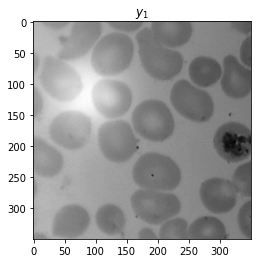

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["image.cmap"] = "gray"  # set default colormap

from tutorial_funcs import load_y1

y1 = load_y1()

print(f"The shape of y1 is {y1.shape}")

fig, ax = plt.subplots()
ax.imshow(y1)
ax.set_title("$y_1$")
fig.show()

The image looks good, except for a distracting bright spot in the upper-left corner.
Based on your knowledge of this microscope,
you suspect that this spot comes from an additive nonuniform illumation,
$$y_1 = x_1 + w,$$
where $x_1$ is the unknown image and $w$ is the unknown illumination.

You want to estimate $x_1$ and $w$ from $y_1$, but the problem as is is hopelessly underdetermined:
$350x350$ measurements and $2x350x350$ unknowns.
You have the idea to move the slide to the left and take another image, $y_2$.

Run the next cell to see $y_1$ and $y_2$.

/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/4209617243.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


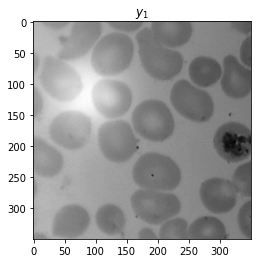

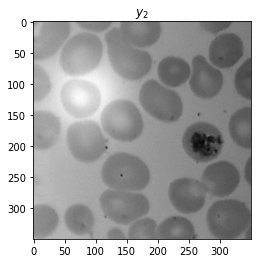

In [2]:
from tutorial_funcs import load_ys

y1, y2 = load_ys()

fig, ax = plt.subplots()
ax.imshow(y1)
ax.set_title("$y_1$")

fig, ax = plt.subplots()
ax.imshow(y2)
ax.set_title("$y_2$")
fig.show()

In reality, we would need to write code to find the offset between $y_1$ and $y_2$.
Here, we'll assume that step is already done.
Run the next cell to find the offset.

In [3]:
from tutorial_funcs import find_offset

offset = find_offset(y1, y2)

print(f"y2 is y1 shifted to the left by {offset} pixels")

y2 is y1 shifted to the left by 50 pixels


You are done with part 1. Please report back in the Webex chat: **done with part 1**.

While you wait for others to finish, you could think about how you would recover $x_1$ and $w$ with the tools you know.

🛑 **PAUSE HERE** 🛑

## Defining a forward model (NumPy version)


We now have the forward model
$$y_1 = x_1 + w$$
$$y_2 = x_2 + w.$$
This is not immediately useful: $2x350x350$ meausurements and $3x350x350$ unknowns.
However, we know that $x_1$ and $x_2$ are parts of a larger image, which we'll call $x$.
In terms of $x$, we have
$$y_1 = C_1x + w,$$
$$y_2 = C_2x + w,$$
where $x$ is $350x400$ and
where $C_1$ and $C_2$ represent two different (known) cropping operations.

**In the cell below, implement this forward model in NumPy.** You can test your forward model by running the cell below that.

In [4]:
def forward(x, w):
    N_cols = w.shape[1]
    y1 = x[:, :N_cols] + w
    y2 = x[:, offset : N_cols + offset] + w
    return y1, y2

/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/545260008.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/545260008.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/545260008.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


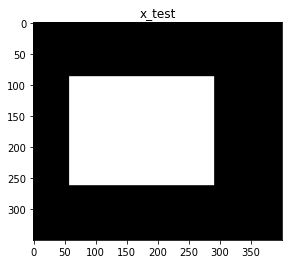

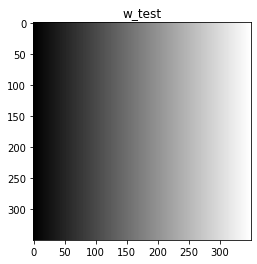

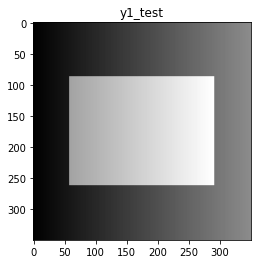

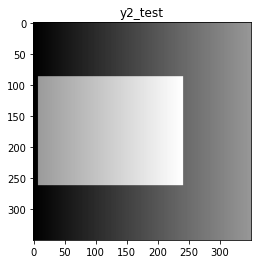

In [5]:
from tutorial_funcs import load_test_solution

x_test, w_test = load_test_solution()

# run the forward model
y1_test, y2_test = forward(x_test, w_test)

(
    fig,
    ax,
) = (
    plt.subplots()
)  # NOTE: not using a single plot so that it is more clear x_test is wider than others
ax.imshow(x_test)
ax.set_title("x_test")
fig.show()

fig, ax = plt.subplots()
ax.imshow(w_test)
ax.set_title("w_test")
fig.show()

fig, ax = plt.subplots()
ax.imshow(y1_test)
ax.set_title("y1_test")

fig, ax = plt.subplots()
ax.imshow(y2_test)
ax.set_title("y2_test")
fig.show()

You are done with part 2. Please report back in the Webex chat: **done with part 2**.

While you wait for others to finish, you could think about measurements systems in your research in terms of forward models.

🛑 **PAUSE HERE** 🛑

## Defining a fowarding model (SCICO version)
SCICO is designed to solve problems of the form $y = Aq$,
where $A$ is the forward model,
$q$ contains the image(s) you want to recover,
and $y$ contains the measurements.
In this section, we'll convert our problem into this form.

A compact way to write our system of equations is
$$ \\underbrace{\begin{bmatrix}y_1 \ y_2 \end{bmatrix}}_{y}
=
\\underbrace{\begin{bmatrix}C_1 & I   \\ C_2 & I  \end{bmatrix}}_{A}
\\underbrace{\begin{bmatrix}x \\ w \end{bmatrix}}_{q} $$

$$y = A q.$$

To represent this equation in SCICO code, we need to (1) convert $y_1$ and $y_2$ into SCICO arrays; (2) stack  $y_1$ and $y_2$ to form $y$; and (3) write the code for $A$.

For step 1, we'll convert $y_1$ and $y_2$ into SCICO arrays and stack them together. Note how we use snp instead of np; this is necessary when we want to use SCICO's operators and solvers.

In [6]:
from tutorial_funcs import load_ys

import scico.numpy as snp

y1, y2 = load_ys()

y1 = snp.array(y1)  # convert to scico arrays
y2 = snp.array(y2)

For step 2 (stacking $y_1$ and $y_2$), note that `scico.numpy` provides most of the functionality of `numpy`.
(See https://scico.readthedocs.io/en/latest/_autosummary/scico.numpy.html#module-scico.numpy)
**Find the appropriate `scico.numpy` function and use it to stack $y_1$ and $y_2$ into a single array.**

In [7]:
y = snp.stack((y1, y2))

For step 3 (define the linear operator $A$) we will first construct a `forward` function.
The challenge is that the function needs to take a single argument, $q$,
whereas our `forward` function from before currently takes $x$ and $w$ separately. Let's first redefine `forward` as a single argument function.

In [8]:
def forward(q):
    x = q[0]
    w = q[1]

    N_cols = w.shape[1]
    y1 = x[:, :N_cols] + w
    y2 = x[:, offset : N_cols + offset] + w
    return snp.stack((y1, y2))

Now let's test `forward`.
To do that, we need to stack `x` and `w`. However, your solution from before won't work. **Explain why.**

We can't stack `x` and `w` because $x$ and $w$ have difference shapes.

We could use padding to allow $x$ and $w$ to stack.
Instead, we can make use of SCICO's representation flexibility afforded via `BlockArray`.
`BlockArray`s are lists of arrays intendend to extend NumPy functionality
(really JAX functionality) over groups of arrays with different shapes. We will use SCICO's `BlockArray`
to stack `x` and `w` together.

In [9]:
from tutorial_funcs import load_test_solution

x_test, w_test = load_test_solution()

q_test = snp.blockarray((x_test, w_test))

The shape of a `BlockArray` is simply a tuple of the shapes of all the components. Run the next cell to check the shape of the constructued `BlockArray`.

In [10]:
q_test.shape

((350, 400), (350, 350))

Now we can test the `BlockArray` version of the forward model.

/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/3227785653.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/3227785653.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/3227785653.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


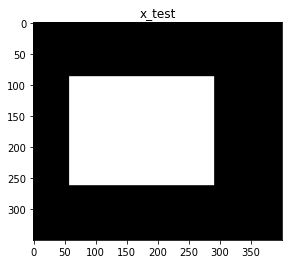

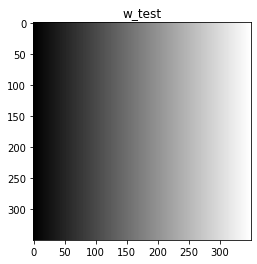

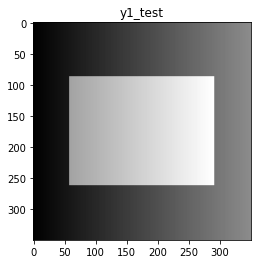

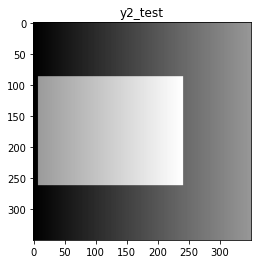

In [11]:
# run the forward model
y_test = forward(q_test)

# plot
fig, ax = plt.subplots()
ax.imshow(x_test)
ax.set_title("x_test")
fig.show()

fig, ax = plt.subplots()
ax.imshow(w_test)
ax.set_title("w_test")
fig.show()

fig, ax = plt.subplots()
ax.imshow(y1_test)
ax.set_title("y1_test")

fig, ax = plt.subplots()
ax.imshow(y2_test)
ax.set_title("y2_test")
fig.show()

Finally,
we can use `forward` to construct the linear operator $A$.
**Read the [documentation on defining a linear operator](https://scico.readthedocs.io/en/latest/operator.html#defining-a-new-linear-operator) and define $A$ in the next cell.**

In [12]:
import scico.linop


A = scico.linop.LinearOperator(input_shape=q_test.shape, eval_fn=forward)

Once we've defined $A$ as a `scico.LinearOperator`,
we can treat it just like a NumPy matrix, including using operators like `A @ q`, `A.T`, `A + A`, and `2*A`.
Run the next cell to see an example of how we could compute $y_1$ and $y_2$
from our previous example.

/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/2376790122.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


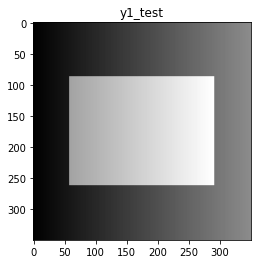

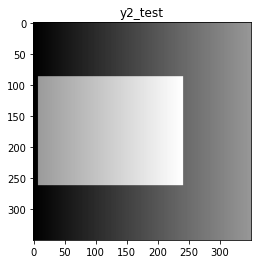

In [13]:
y_test = A @ q_test

fig, ax = plt.subplots()
ax.imshow(y1_test)
ax.set_title("y1_test")

fig, ax = plt.subplots()
ax.imshow(y2_test)
ax.set_title("y2_test")
fig.show()

You are done with part 3. Please report back in the Webex chat: **done with part 3**.

While you wait for others to finish, you could think about what $A^T$ should do and try to plot it in the cell below.

In [14]:
# this cell intentionally left blank

🛑 **PAUSE HERE** 🛑

# Solving the Nonuniform Illumination Problem: SCICO CG Solver
To solve this problem with SCICO,
we can put it into the form
$$ \min_q \| y - Aq \|_2^2,$$
where $y$ is an array, $q$ is a `BlockArray`,
and $A$ is a `scico.LinearOperator`.

Since now we have all the components in place, we  are ready to solve. Because this is a least squares problem, a good approach is to equate the gradient to zero
and solve with the conjugate gradient (CG) method. The gradient is

$$A^T A q - A^T y.$$

Note that the gradient computation requires $A^T$.
One of the advantages of using SCICO is that it uses JAX autograd functionality for computing these expressions avoiding the need to implement them explicitly. We can test the $A^T$ operator available with the definition of the `LinearOperator`.

AT_eval.shape:  ((350, 400), (350, 350))


/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/4126247236.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


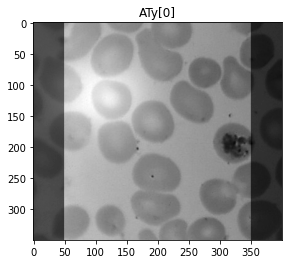

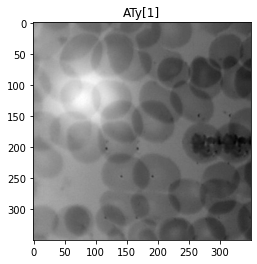

In [15]:
ATy = A.T @ y

print("AT_eval.shape: ", ATy.shape)

fig, ax = plt.subplots()
ax.imshow(ATy[0])
ax.set_title("ATy[0]")

fig, ax = plt.subplots()
ax.imshow(ATy[1])
ax.set_title("ATy[1]")
fig.show()

Take a look at the documentation for `scico.solver.cg`: https://scico.readthedocs.io/en/latest/_autosummary/scico.solver.html#scico.solver.cg and try to use it to find the $q$ that makes the gradient zero.

In [16]:
import scico.solver


q_hat, info = scico.solver.cg(A.T @ A, A.T @ y, snp.zeros(A.input_shape))

print(info)

{'num_iter': 14, 'rel_res': DeviceArray(9.700574e-07, dtype=float32)}


Run the cell below to see your results!

/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/683500752.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/683500752.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/683500752.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


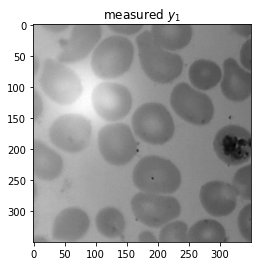

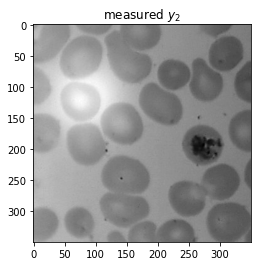

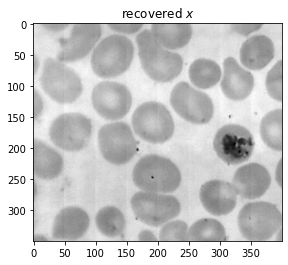

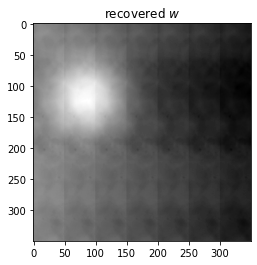

In [17]:
x_hat = q_hat[0]
w_hat = q_hat[1]

# plot
fig, ax = plt.subplots()
ax.imshow(y1)
ax.set_title("measured $y_1$")
fig.show()

fig, ax = plt.subplots()
ax.imshow(y2)
ax.set_title("measured $y_2$")
fig.show()

fig, ax = plt.subplots()
ax.imshow(x_hat)
ax.set_title("recovered $x$")

fig, ax = plt.subplots()
ax.imshow(w_hat)
ax.set_title("recovered $w$")
fig.show()

You are done with part 4. Please report back in the Webex chat: **done with part 4**.

While you wait for others to finish, you could think about what you like and dislike about the solution you got.
How could you improve it?
How do you know if it is correct?

🛑 **PAUSE HERE** 🛑

## Refining the solution with regularization

If we closely inspect the recovered `x` solution, we can see that it exhibits
some artifacts. In several cases we can improve the quality of results by seeking for a regularized least squares solution

$$ \min_q \| y - Aq \|_2^2 + \, r(q),$$

where $r$ is an appropriate regularization.

In this case,
we look for a solution with a smooth `w`. This can be expressed as the minimization of the $L_2$ norm of its gradients in $x$ and $y$ directions

$$ \min_q \| y - Aq \|_2^2 + \alpha\| D q \|_2^2,$$

where $Dq = D_w w$, and $D_w$ computes finite differences.
SCICO provides an operator to compute these gradients.
**Look through the [list of SCICO operators](https://scico.readthedocs.io/en/latest/_autosummary/scico.linop.html#module-scico.linop) to find the appropriate one
and instantiate it.**

In [18]:
Dw = scico.linop.FiniteDifference(input_shape=w_test.shape)

Run the next cell to see $D$ in action.

/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/2681012173.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.5, 1.0, '$\\nabla_y y_1$')

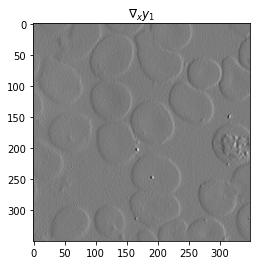

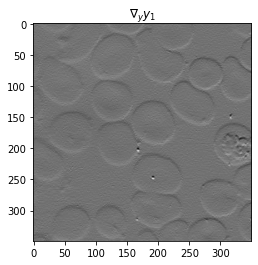

In [19]:
Dwy1 = Dw @ y1


fig, ax = plt.subplots()
ax.imshow(Dwy1[1])
ax.set_title(r"$\nabla_x y_1$")
fig.show()

fig, ax = plt.subplots()
ax.imshow(Dwy1[0])
ax.set_title(r"$\nabla_y y_1$")

Note, however, that we want to regularize for $w$ being smooth and this is only a part of $q$, the complete unknown we are solving for.
We need an operator that can index into $q$ (this operation is called slicing in Python);
SCICO has an operator for that!
**Look through the [list of SCICO operators](https://scico.readthedocs.io/en/latest/_autosummary/scico.linop.html#module-scico.linop) to find the appropriate one
and instantiate it.**

In [20]:
S = scico.linop.Slice(idx=1, input_shape=q_test.shape)

Let's test this new operator.

/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/3527125466.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


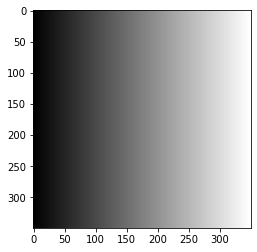

In [21]:
w_test = S @ q_test

fig, ax = plt.subplots()
ax.imshow(w_test)
fig.show()

**In the next cell, combine `Dw` and `S` to make D.** Remember that SCICO supports matrix-like operations on operators.

In [22]:
D = Dw @ S

We are now ready to solve.
We can still use the conjugate gradient (CG) method, we just need to compute the gradient including the regularization

$$A^T A q + \alpha D^T D - A^T y.$$

**In the next cell, fill in the CG solver.**

In [24]:
alpha = 1.0

q_hat, info = scico.solver.cg(A.T @ A + alpha * D.T @ D, A.T @ y, snp.zeros(A.input_shape))

print(info)

{'num_iter': 263, 'rel_res': DeviceArray(9.429049e-06, dtype=float32)}


Run the cell below to see your results!

/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/683500752.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/683500752.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/683500752.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


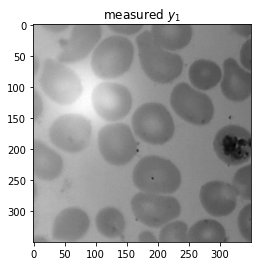

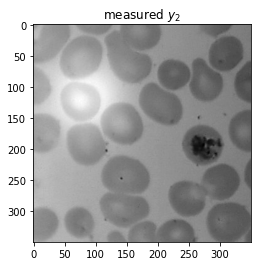

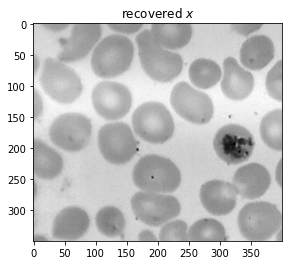

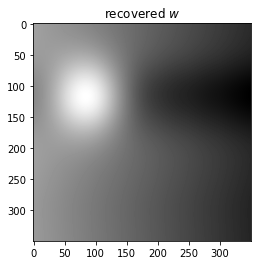

In [25]:
x_hat = q_hat[0]
w_hat = q_hat[1]

# plot
fig, ax = plt.subplots()
ax.imshow(y1)
ax.set_title("measured $y_1$")
fig.show()

fig, ax = plt.subplots()
ax.imshow(y2)
ax.set_title("measured $y_2$")
fig.show()

fig, ax = plt.subplots()
ax.imshow(x_hat)
ax.set_title("recovered $x$")

fig, ax = plt.subplots()
ax.imshow(w_hat)
ax.set_title("recovered $w$")
fig.show()

You are done with part 5. Please report back in the Webex chat: **done with part 5**.

While you wait for others to finish, you could think about what effect $\alpha$ should have on your solution.
Try changing it.
What trade off does it control?
How can you pick the best value?

🛑 **PAUSE HERE** 🛑

## Refining the Solution: SCICO Functionals, Losses, Optimizers

If we closely inspect our recovered `x` we can see that it has negative values,
which might be nonphysical.

In [26]:
print("Range of solution")
print("Minimum x: ", x_hat.min())
print("Maximum x: ", x_hat.max())
print("Minimum w: ", w_hat.min())
print("Maximum w: ", w_hat.max())

Range of solution
Minimum x:  -0.15183662
Maximum x:  0.8135038
Minimum w:  0.2911266
Maximum w:  1.1348518


We can add another regularization term to enforce that $x$ and $w$ are nonnegative

$$\min_q \| y - Aq \|_2^2, + \, r_1(q) + \, r_2(q)$$

$r_1$ is the previously defined smoothness regularization and $r_2$ is the nonnegative constraint.

The nonnegative constraint is implemented in SCICO as a nonnegative indicator functional.
Since this is a nonsmooth functional, it is necessary to use a different solver for this
formulation. In this case, we will use the Proximal Gradient Method `PGM`
(see https://scico.readthedocs.io/en/latest/_autosummary/scico.optimize.html#scico.optimize.PGM)

The `PGM` optimizer solves problems of the form

$$\min_x f(x) + g(x),$$

wher $f$ is a smooth function and $g$ is a function with a proximal map. Therefore, we need to cast our problem
 following the PGM structure. We do it as follows

 $$f(q) = \| y - Aq \|_2^2 + \alpha \| D q \|_2^2,$$
 $$g(q) = \iota_{\mathbb{NN}}(q),$$

with $\iota_{\mathbb{NN}}$ representing a nonnegative indicator function. In this way, we group the derivable (smooth) part
 of optimization problem in $f$, using a regularization hyper-parameter $\alpha > 0$ to trade-off fidelity vs.
 smoothness and keep the non-smooth part in $g$.

We show next how we can achieve this using SCICO losses and functionals.

In [27]:
from scico import functional, loss

First, we express the fidelity term $\| y - Aq \|_2^2,$ using a `scico.loss`.
**Use the [loss docs](https://scico.readthedocs.io/en/latest/_autosummary/scico.loss.html#module-scico.loss) to find the appropriate way to express this data fidelity term in SCICO.**

In [28]:
# y and A included here for readability but are defined as before
y = snp.stack((y1, y2))
A = scico.linop.LinearOperator(input_shape=q_test.shape, eval_fn=forward)


f_data = loss.SquaredL2Loss(y=y, A=A)

**Define a loss to quantify the smoothness of $w$, $\| D w \|_2^2$**.

In [29]:
f_smoothness = loss.SquaredL2Loss(y=snp.zeros(D.output_shape), A=D)

To form $f$ from above, we need to make the sum of `f_data` and `f_smoothness`.
Luckily, SCICO supports algebra on losses, just like it does on operators.
**Make $f$ in the cell below.**

In [30]:
alpha = 1.0

f = f_data + alpha * f_smoothness

Now we define the nonnegative indicator function, $g$.
**Use the [functional docs](https://scico.readthedocs.io/en/latest/_autosummary/scico.functional.html#module-scico.functional) to find the appropriate way to express this data fidelity term in SCICO.**

In [31]:
g = functional.NonNegativeIndicator()

We set up a PGM optimizer to compute the regularized solution.

In [32]:
from scico.optimize.pgm import AcceleratedPGM

L0 = 1e2  # Initial inverse of stepsize
maxiter = 200  # Maximum iterations to compute
x0 = snp.zeros(q_test.shape)  # Initial estimate of the solution

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True},
)

Run the next cell to see an example of running PGM to compute $y_1$ and $y_2$
from our previous setup.

In [33]:
q_hat = solver.solve()

Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  2.61e-01  1.624e+05  1.000e+02  1.162e+01
   1  8.15e-01  1.502e+05  1.000e+02  1.117e+01
   2  8.37e-01  1.358e+05  1.000e+02  1.061e+01
   3  8.59e-01  1.200e+05  1.000e+02  9.970e+00
   4  8.80e-01  1.036e+05  1.000e+02  9.255e+00
   5  9.01e-01  8.734e+04  1.000e+02  8.486e+00
   6  9.21e-01  7.175e+04  1.000e+02  7.678e+00
   7  9.45e-01  5.734e+04  1.000e+02  6.847e+00
   8  9.79e-01  4.445e+04  1.000e+02  6.011e+00
   9  1.01e+00  3.333e+04  1.000e+02  5.182e+00
  10  1.04e+00  2.405e+04  1.000e+02  4.376e+00
  11  1.06e+00  1.662e+04  1.000e+02  3.604e+00
  12  1.09e+00  1.091e+04  1.000e+02  2.878e+00
  13  1.11e+00  6.750e+03  1.000e+02  2.209e+00
  14  1.13e+00  3.907e+03  1.000e+02  1.606e+00
  15  1.16e+00  2.132e+03  1.000e+02  1.083e+00
  16  1.18e+00  1.171e+03  1.000e+02  6.654e-01
  17  1.20e+00  7.857e+02  1.000e+02  4.346e-01
  18  1.23e+00  7.678e+02  1.000e+02  4.

 169  4.86e+00  9.305e-01  1.000e+02  5.214e-03
 170  4.88e+00  9.374e-01  1.000e+02  5.291e-03
 171  4.91e+00  9.469e-01  1.000e+02  5.380e-03
 172  4.93e+00  9.585e-01  1.000e+02  5.487e-03
 173  4.95e+00  9.716e-01  1.000e+02  5.616e-03
 174  4.98e+00  9.856e-01  1.000e+02  5.762e-03
 175  5.00e+00  9.999e-01  1.000e+02  5.915e-03
 176  5.02e+00  1.014e+00  1.000e+02  6.062e-03
 177  5.04e+00  1.027e+00  1.000e+02  6.190e-03
 178  5.07e+00  1.040e+00  1.000e+02  6.286e-03
 179  5.09e+00  1.050e+00  1.000e+02  6.339e-03
 180  5.11e+00  1.060e+00  1.000e+02  6.342e-03
 181  5.14e+00  1.067e+00  1.000e+02  6.292e-03
 182  5.16e+00  1.073e+00  1.000e+02  6.193e-03
 183  5.18e+00  1.077e+00  1.000e+02  6.043e-03
 184  5.20e+00  1.080e+00  1.000e+02  5.857e-03
 185  5.23e+00  1.082e+00  1.000e+02  5.644e-03
 186  5.25e+00  1.084e+00  1.000e+02  5.417e-03
 187  5.27e+00  1.086e+00  1.000e+02  5.192e-03
 188  5.30e+00  1.088e+00  1.000e+02  4.982e-03
 189  5.32e+00  1.090e+00  1.000e+02  4.

Run the cell below to see your results!

/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/683500752.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/683500752.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/7_/2g67t60s43x__qm8hlwf1l5w0000gr/T/ipykernel_16164/683500752.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


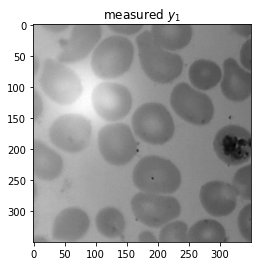

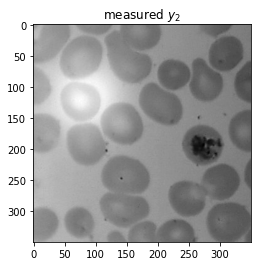

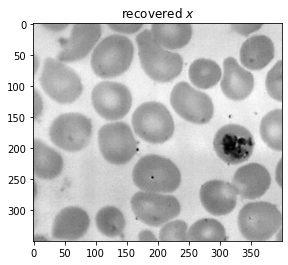

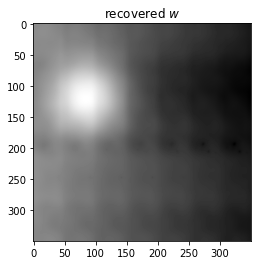

In [34]:
x_hat = q_hat[0]
w_hat = q_hat[1]

# plot
fig, ax = plt.subplots()
ax.imshow(y1)
ax.set_title("measured $y_1$")
fig.show()

fig, ax = plt.subplots()
ax.imshow(y2)
ax.set_title("measured $y_2$")
fig.show()

fig, ax = plt.subplots()
ax.imshow(x_hat)
ax.set_title("recovered $x$")

fig, ax = plt.subplots()
ax.imshow(w_hat)
ax.set_title("recovered $w$")
fig.show()

Run the cell below to check if the nonnegativity constraint worked.

In [35]:
print("Range of solution")
print("Minimum: ", x_hat.min())
print("Maximum: ", x_hat.max())
print("Minimum: ", w_hat.min())
print("Maximum: ", w_hat.max())

Range of solution
Minimum:  0.0
Maximum:  0.7728735
Minimum:  0.3207509
Maximum:  1.1964254


## Conclusion
This tutorial has shown how to set up and solve a simple least squares imaging problem in
SCICO as well as regularized least squares formulations. In doing so, it has demonstrated
a diverse set of classes provided by SCICO such as operators, functionals, losses and
solvers which make expressing regularized optimization problems more straightforward.

You are done with the tutorial! Please report back in the Webex chat: **done with the tutorial**.

While you wait for others to finish, you could check out the [PGM documentation](https://scico.readthedocs.io/en/latest/_autosummary/scico.optimize.html#scico.optimize.PGM) and [PGM step size documentation](https://scico.readthedocs.io/en/latest/_autosummary/scico.optimize.pgm.html) to understand more of the arguments to `AcceleratedPGM`.